In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
import math

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 300
X, y = make_classification(n_samples = 2000, n_features = n_features, n_informative = 100, n_clusters_per_class=10, n_redundant=100, n_repeated=0, flip_y=0.01, random_state=2, class_sep=3)
X_train, X_test = np.split(X, [500])
y_train, y_test = np.split(y, [500])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

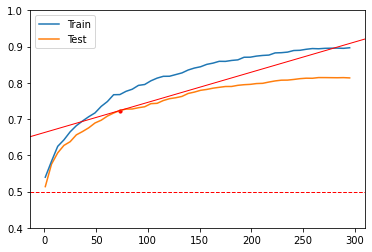

AT (73, 0.7236, 0.2697866666666667) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:03.957231500


In [5]:
#RANDOM_SELECTION(0.00001)

# SVM-RFE

In [5]:
@time_func
def SVM_RFE_W_STEP(step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6, sampling_p = 0.5, dstep_p = 0.1, dstop = 1):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    data.sampling_percentagee = sampling_p
    data.dstep_percentage = dstep_p
    data.dstop = dstop
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_combo, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))

    print(kernel, C, degree, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time, (np.mean(all_scores), err)

rbf 1 6 0.00056


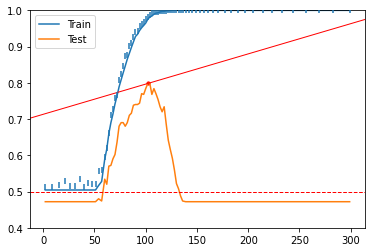

AT (102, 0.7982338475296222, 0.22941292197630223) WITH 74 ITERATIONS IN 18.086850677217758 SECONDS : 0.13342234917832468
__main__.SVM_RFE_W_STEP - 00:00:22.113380500
rbf 10 6 0.00056


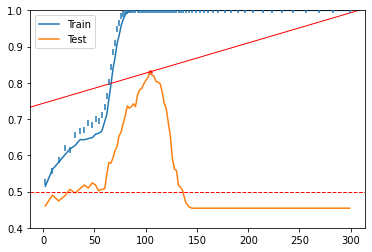

AT (104, 0.830147551978538, 0.20521529175050296) WITH 74 ITERATIONS IN 17.783278431211198 SECONDS : 0.0402199331413065
__main__.SVM_RFE_W_STEP - 00:00:21.440223000
rbf 100 6 0.00056


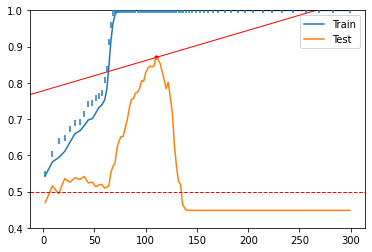

AT (110, 0.8699418734630002, 0.17737983456293316) WITH 74 ITERATIONS IN 17.723704031535558 SECONDS : 0.060558768480952534
__main__.SVM_RFE_W_STEP - 00:00:21.555148500
rbf 1000 6 0.00056


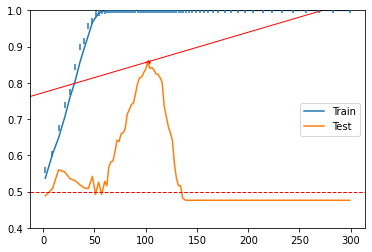

AT (102, 0.8579253297563156, 0.18165973619494752) WITH 74 ITERATIONS IN 17.655141523906163 SECONDS : 0.03939652582436783
__main__.SVM_RFE_W_STEP - 00:00:21.569088800
rbf 10000 6 0.00056


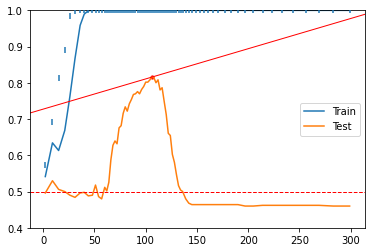

AT (106, 0.8158674267829198, 0.21797272524033084) WITH 74 ITERATIONS IN 19.311053207942418 SECONDS : 0.037168528832397414
__main__.SVM_RFE_W_STEP - 00:00:23.223634400
rbf 100000 6 0.00056


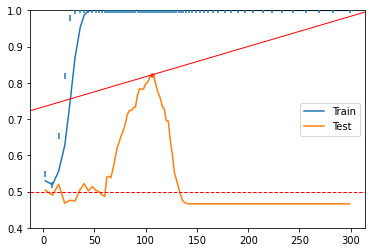

AT (106, 0.8220154258886653, 0.21305432595573448) WITH 74 ITERATIONS IN 22.19781678063529 SECONDS : 0.03332687555984639
__main__.SVM_RFE_W_STEP - 00:00:26.555350600


In [31]:
model_selection = {}
for g in [0.00056]:
    for C in [1, 10, 100, 1000, 10000, 100000]:
        model_selection[C, g] = SVM_RFE_W_STEP(kernel='rbf', gamma=g, C=C, dstop=100, dstep_p=0.08, sampling_p=0.6, step=2)

In [32]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.0e}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.00056: 1}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1e+00} &   102 & 79.82\% & 0.229 &  & \\
\textbf{1e+01} &   104 & 83.01\% & 0.205 &  & \\
\textbf{1e+02} &   110 & 86.99\% & 0.177 &  & \\
\textbf{1e+03} &   102 & 85.79\% & 0.182 &  & \\
\textbf{1e+04} &   106 & 81.59\% & 0.218 &  & \\
\textbf{1e+05} &   106 & 82.20\% & 0.213 &  & \\


In [23]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.0e}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(math.floor(v[1]/60.0), str(int(v[1] % 60)), str(int((v[1] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{1e-10} & 0:08.003 & 0:08.314 & 0:08.781\\
\textbf{1e-09} & 0:07.922 & 0:08.231 & 0:08.670\\
\textbf{1e-08} & 0:07.928 & 0:08.341 & 0:08.646\\
\textbf{1e-07} & 0:08.075 & 0:08.506 & 0:08.523\\
\textbf{1e-06} & 0:08.035 & 0:07.961 & 0:08.453\\
\textbf{1e-05} & 0:08.198 & 0:07.834 & 0:08.525\\
\textbf{1e-04} & 0:07.956 & 0:07.739 & 0:08.571\\
\textbf{1e-03} & 0:06.849 & 0:07.851 & 0:08.461\\
\textbf{1e-02} & 0:06.134 & 0:08.189 & 0:08.510\\
\textbf{1e-01} & 0:05.541 & 0:08.097 & 0:08.582\\
